In [1]:
import numpy as np
from fft_tdse.simulator import *
from fft_tdse.animator import *
import matplotlib.pyplot as plt


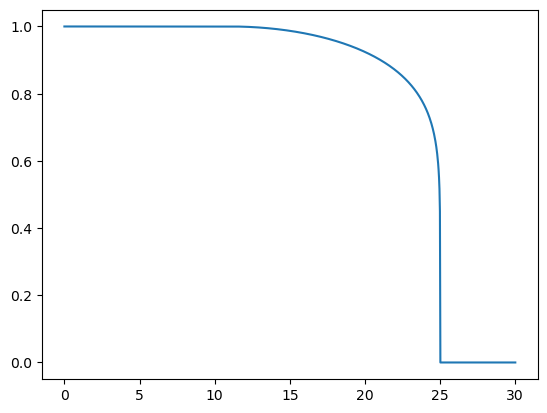

In [2]:
x_min = -25
x_max = 25
nx = 64
dim = 4


def potential2(x, y, ell=0.111803):
    return 0.5*(x**2 + y**2) + ell*(x**2*y - y**3/3)

def potential3(x, y, z, ell=0.111803):
    return 0.5*(x**2 + y**2 + z**2) + ell*(x**2*y - y**3/3 + y**2*z - z**3/3)

def potential4(x, y, z, w, ell=0.111803):
    return 0.5*(x**2 + y**2 + z**2 + w**2) + ell*(x**2*y - y**3/3 + y**2*z - z**3/3 + z**2*w - w**3/3)

def initial_condition2(x, y):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2)) / np.pi**.5

def initial_condition3(x, y, z):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2 + (z-2)**2)) / np.pi**.75

def initial_condition4(x, y, z, w):
    # normalized gaussian
    return np.exp(-0.5*((x-2)**2 + (y-2)**2 + (z-2)**2 + (w-2)**2)) / np.pi**1

def mask_r(r):
    r0 = 11
    r1 = 25
    # interpolate between r0 and r1 using a cosine function
    mask = np.zeros_like(r)
    mask = (r > r0) * (r < r1) * np.cos((r-r0)/(r1-r0)*np.pi/2)
    mask[r < r0] = 1
    mask **= 0.125
    return mask

def mask2(x,y):
    r0 = 11
    r1 = 25
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2)
    return mask_r(r)

def mask3(x,y,z):
    r0 = 11
    r1 = 25
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2 + z**2)
    return mask_r(r)

def mask4(x,y,z,w):
    r0 = 11
    r1 = 25
    # interpolate between r0 and r1 using a cosine function
    r = np.sqrt(x**2 + y**2 + z**2 + w**2)
    return mask_r(r)

if dim == 2:
    potential = potential2
    initial_condition = initial_condition2
    mask = mask2
elif dim == 3:
    potential = potential3
    initial_condition = initial_condition3
    mask = mask3
elif dim == 4:
    potential = potential4
    initial_condition = initial_condition4
    mask = mask4
    
plt.figure()
rr =  np.linspace(0, 30, 1000)
plt.plot(rr, mask_r(rr))
plt.show()



In [3]:
sim = Simulator(verbose=True)
sim.set_dimension(dim)
sim.set_mass(1.0)
sim.set_potential(potential)
sim.set_initial_condition(initial_condition)
sim.set_grid([x_min]*dim, [x_max]*dim, [nx]*dim)

ic| simulator.py:283 in set_propagator() at 13:14:14.326
ic| message: 'Propagation method set to "strang-3"'
ic| message: 'Dimension set to 4'
ic| message: 'Initial condition set.'
ic| self.initial_psi_fun: <function initial_condition4 at 0x1406c36d0>
ic| message: 'Grid set.'
ic| self.a: array([-25., -25., -25., -25.])
    self.b: array([25., 25., 25., 25.])
    self.n: array([64, 64, 64, 64])


In [4]:
sim.set_time_parameters(0.0, 100.0, 2000)

ic| 'Time parameters set.'
ic| self.t0: 0.0, self.t1: 100.0, self.n_steps: 2000


In [5]:
sim.prepare()

ic| 'Using given initial condition function. '


In [6]:
V = sim.ham.V
psi0 = sim.wf.psi.copy()


In [7]:
sim.prepare()

#anim1 = Animator2d(sim, name = 'henon_heiles')
# anim1.vis_type = 'complex'
# anim1.show_axis = False
# anim1.xlim = [-40, 40]
# anim1.ylim = [-40, 40]
# anim1.mag_map = lambda r: r**1
# anim1.set_interval(10)
# anim1.set_framesize(1024, 1024)

# # initialize figure, and add potential visualization
# anim1.init_figure()


# anim_callback1 = anim1.get_callback()
# anim1.caption_format = 't = {sim.t:.02f}'

acorr = np.zeros_like(sim.t_grid, dtype=complex)
def callback(sim):
    if sim.t_index % 10 == 0:
        if dim == 2:
            sim.psi = sim.psi * mask2(sim.x, sim.y)
        elif dim == 3:
            sim.psi = sim.psi * mask3(sim.x, sim.y, sim.z)
        elif dim == 4:
            sim.psi = sim.psi * mask4(sim.x, sim.y, sim.z, sim.w)
    acorr[sim.t_index] = np.sum(sim.psi * np.conj(psi0)) * sim.grid.dtau
    
    #psi_out = np.where((np.abs(sim.x) > 40) | (np.abs(sim.y) > 40), sim.psi, np.zeros_like(sim.psi))
#    P_hist[sim.t_index] = np.sum(np.abs(psi_out)**2) * sim.grid.dtau
#    sim.P_ionized = P_hist[sim.t_index]
#    anim_callback1(sim)
    
    
sim.simulate(callback=callback)
#anim1.make_movie("henon_heiles.mp4")
#anim1.clean_frames()


ic| 'Using given initial condition function. '
ic| 'Running simulation...'


  0%|          | 0/2000 [00:00<?, ?it/s]

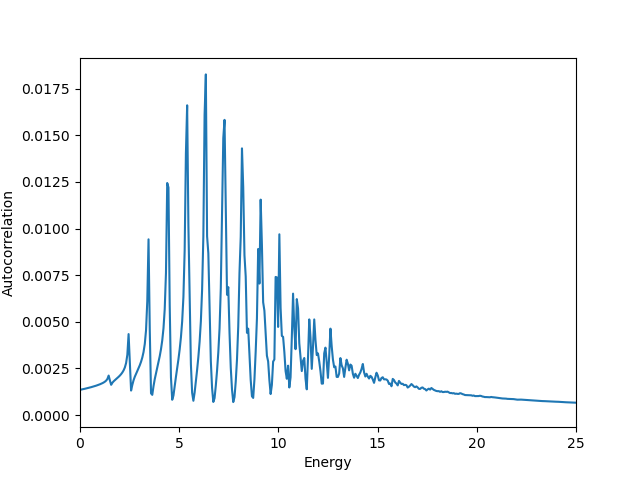

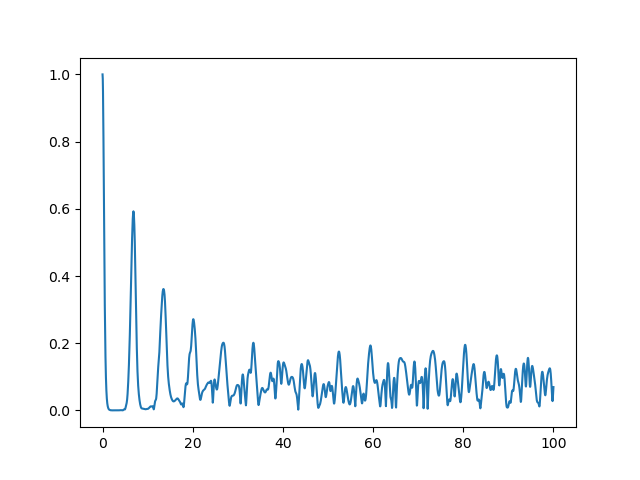

In [100]:
%matplotlib widget
plt.close('all')
plt.figure()
fourier_acorr = np.fft.fftshift(np.fft.ifft(acorr * np.exp(-sim.t_grid/30)  ))
omega = np.fft.fftshift(np.fft.fftfreq(len(sim.t_grid), sim.dt)) * 2 * np.pi
plt.plot(omega, np.abs(fourier_acorr))
plt.xlim(0, 25)
plt.xlabel('Energy')
plt.ylabel('Autocorrelation')
plt.show()

# plot the autocorrelation
plt.figure()
plt.plot(sim.t_grid, np.abs(acorr))
plt.show()



In [ ]:
sim.ham.D

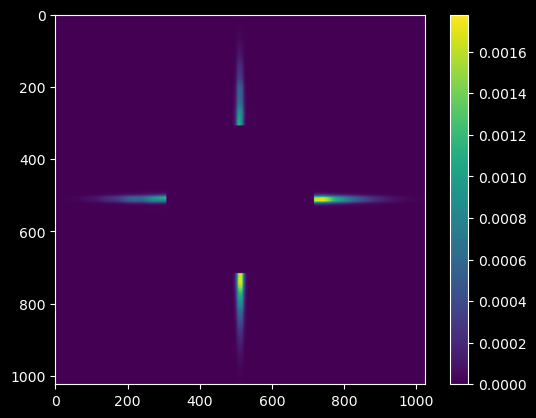

In [27]:
psi_out = np.where((np.abs(sim.x) > 40) | (np.abs(sim.y) > 40), sim.psi, np.zeros_like(sim.psi))
plt.figure()

plt.imshow(np.abs(psi_out))
plt.colorbar()

In [11]:
help(np.where)

Help on _ArrayFunctionDispatcher in module numpy:

where(...)
    where(condition, [x, y], /)
    
    Return elements chosen from `x` or `y` depending on `condition`.
    
    .. note::
        When only `condition` is provided, this function is a shorthand for
        ``np.asarray(condition).nonzero()``. Using `nonzero` directly should be
        preferred, as it behaves correctly for subclasses. The rest of this
        documentation covers only the case where all three arguments are
        provided.
    
    Parameters
    ----------
    condition : array_like, bool
        Where True, yield `x`, otherwise yield `y`.
    x, y : array_like
        Values from which to choose. `x`, `y` and `condition` need to be
        broadcastable to some shape.
    
    Returns
    -------
    out : ndarray
        An array with elements from `x` where `condition` is True, and elements
        from `y` elsewhere.
    
    See Also
    --------
    choose
    nonzero : The function that is called